In [1]:
import sqlite3
import csv

# Path to your CSV file
file_path = 'weather_forecast_data.csv'

# Create a SQLite in-memory database and establish a connection
connection = sqlite3.connect(":memory:")
cursor = connection.cursor()

# Create the normalized database schema
# Create the Rain_Status table
cursor.execute("""
CREATE TABLE Rain_Status (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Rain_Status TEXT UNIQUE
);
""")

# Create the Weather_Conditions table
cursor.execute("""
CREATE TABLE Weather_Conditions (
    ID INTEGER PRIMARY KEY AUTOINCREMENT,
    Temperature REAL,
    Humidity REAL,
    Wind_Speed REAL,
    Cloud_Cover REAL,
    Pressure REAL,
    Rain_Status_ID INTEGER,
    FOREIGN KEY (Rain_Status_ID) REFERENCES Rain_Status(ID)
);
""")

# Populate the Rain_Status table
rain_statuses = [("rain",), ("no rain",)]
cursor.executemany("INSERT INTO Rain_Status (Rain_Status) VALUES (?)", rain_statuses)

# Read data from the CSV file and populate the Weather_Conditions table
with open(file_path, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        # Get the Rain_Status_ID corresponding to the Rain column
        cursor.execute("SELECT ID FROM Rain_Status WHERE Rain_Status = ?", (row['Rain'],))
        rain_status_id = cursor.fetchone()[0]

        # Insert the weather record into Weather_Conditions
        cursor.execute("""
        INSERT INTO Weather_Conditions (
            Temperature, Humidity, Wind_Speed, Cloud_Cover, Pressure, Rain_Status_ID
        ) VALUES (?, ?, ?, ?, ?, ?)""", 
        (row['Temperature'], row['Humidity'], row['Wind_Speed'], row['Cloud_Cover'], row['Pressure'], rain_status_id))

# Commit changes to the database
connection.commit()

# Example: Query and display some data from the database
print("Rain_Status Table:")
for row in cursor.execute("SELECT * FROM Rain_Status"):
    print(row)

print("\nWeather_Conditions Table:")
for row in cursor.execute("SELECT * FROM Weather_Conditions LIMIT 5"):
    print(row)

# Close the database connection
connection.close()


Rain_Status Table:
(1, 'rain')
(2, 'no rain')

Weather_Conditions Table:
(1, 23.720337598183118, 89.59264065174611, 7.335604391040214, 50.501693832913155, 1032.378758690279, 1)
(2, 27.879734159310487, 46.48970403534824, 5.952483593282764, 4.990052927536981, 992.6141895121403, 2)
(3, 25.069084401791095, 83.07284289257146, 1.3719918180799207, 14.855783939243427, 1007.2316201172738, 2)
(4, 23.622079574922424, 74.36775792086564, 7.050550632784658, 67.25528206034686, 982.6320127095369, 1)
(5, 20.591369983472617, 96.85882241307947, 4.6439209259534975, 47.67644427890656, 980.8251417426507, 2)


In [3]:
import sqlite3
import pandas as pd

# Define the database file path
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'

# Connect to the database
conn = sqlite3.connect(db_path)

# SQL query to join tables and fetch denormalized data
query = """
SELECT 
    wc.temperature,
    wc.humidity,
    wc.wind_speed,
    wc.pressure,
    cc.cloud_cover,
    rs.rain_status
FROM 
    WeatherRecords wr
JOIN 
    WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN 
    CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN 
    RainStatus rs ON wr.rain_status_id = rs.id;
"""

# Execute the query and load the data into a Pandas DataFrame
denormalized_data = pd.read_sql_query(query, conn)

# Close the database connection
conn.close()

# Display the resulting DataFrame
print(denormalized_data)

# Save to a CSV file for reference if needed
output_csv_path = '/Users/vijaykrishnareddy/Downloads/denormalized_weather_data.csv'
denormalized_data.to_csv(output_csv_path, index=False)
print(f"Denormalized data saved to: {output_csv_path}")


      temperature   humidity  wind_speed     pressure  cloud_cover rain_status
0       23.720338  89.592641    7.335604  1032.378759    50.501694        rain
1       27.879734  46.489704    5.952484   992.614190     4.990053     no rain
2       25.069084  83.072843    1.371992  1007.231620    14.855784     no rain
3       23.622080  74.367758    7.050551   982.632013    67.255282        rain
4       20.591370  96.858822    4.643921   980.825142    47.676444     no rain
...           ...        ...         ...          ...          ...         ...
2495    21.791602  45.270902   11.807192  1017.686181    55.044682     no rain
2496    27.558479  46.481744   10.884915  1008.590961    39.715133     no rain
2497    28.108274  43.817178    2.897128   999.119187    75.842952     no rain
2498    14.789275  57.908105    2.374717  1046.501875     2.378743     no rain
2499    26.554356  97.101517   18.563084  1001.729176    81.357508     no rain

[2500 rows x 6 columns]
Denormalized data saved to:

Rain Status Distribution in the Full Dataset:
Rain
no rain    0.8744
rain       0.1256
Name: proportion, dtype: float64

Other feature distributions:
       Temperature     Humidity   Wind_Speed  Cloud_Cover     Pressure
count  2500.000000  2500.000000  2500.000000  2500.000000  2500.000000
mean     22.581725    64.347094     9.906255    49.658104  1014.312336
std       7.326996    19.954739     5.780316    29.123104    20.196433
min      10.001842    30.005071     0.009819     0.015038   980.014486
25%      16.359398    47.339815     4.761909    23.900016   996.938630
50%      22.536448    63.920797     9.908572    49.488284  1013.433035
75%      28.976476    81.561021    14.948408    75.324140  1031.735067
max      34.995214    99.997481    19.999132    99.997795  1049.985593

Train Set Distribution:
Rain
no rain    0.8745
rain       0.1255
Name: proportion, dtype: float64

Test Set Distribution:
Rain
no rain    0.874
rain       0.126
Name: proportion, dtype: float64


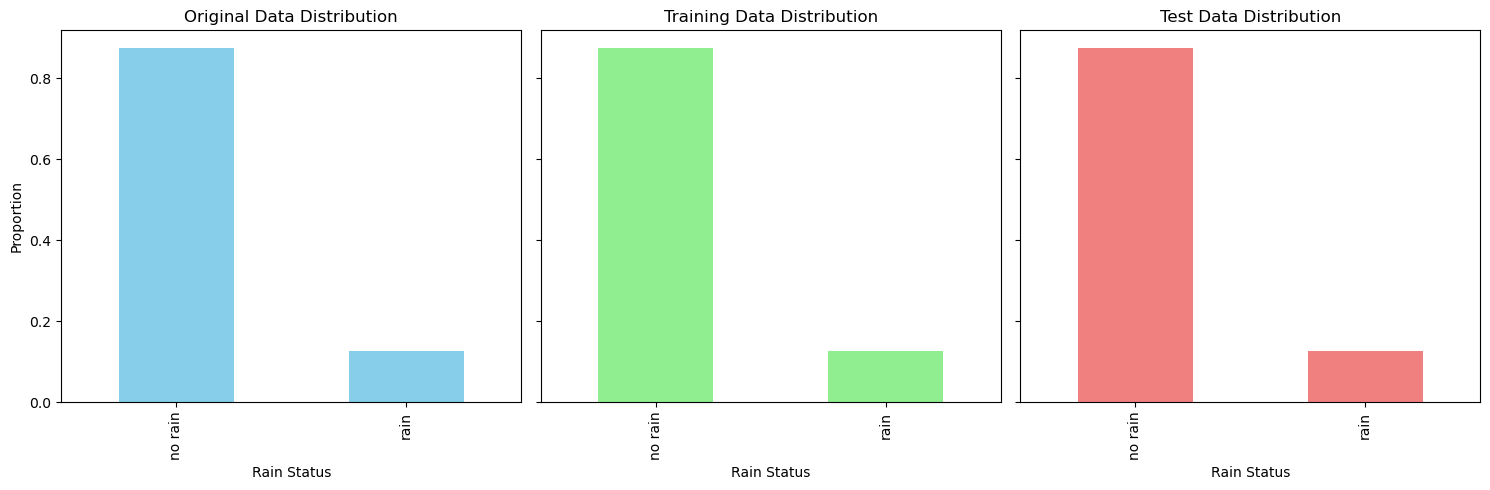

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load your dataset (replace the path with your actual file path)
csv_file_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_data.csv'
df = pd.read_csv(csv_file_path)

# Step 1: Explore the data distribution of rain_status
rain_status_distribution = df['Rain'].value_counts(normalize=True)
print("Rain Status Distribution in the Full Dataset:")
print(rain_status_distribution)

# Optionally, explore other features (if needed for stratification)
print("\nOther feature distributions:")
print(df.describe())  # Basic stats for numerical features

# Step 2: Separate features (X) and target (y)
X = df.drop(columns=['Rain'])  # Features
y = df['Rain']  # Target

# Step 3: Perform Stratified Train/Test Split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Check the distribution in the splits
train_distribution = y_train.value_counts(normalize=True)
test_distribution = y_test.value_counts(normalize=True)

print("\nTrain Set Distribution:")
print(train_distribution)

print("\nTest Set Distribution:")
print(test_distribution)

# Step 5: Plot the class distributions for the original, training, and test datasets
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Original dataset distribution
rain_status_distribution.plot(kind='bar', ax=axes[0], title='Original Data Distribution', color='skyblue')
axes[0].set_xlabel('Rain Status')
axes[0].set_ylabel('Proportion')

# Training dataset distribution
train_distribution.plot(kind='bar', ax=axes[1], title='Training Data Distribution', color='lightgreen')
axes[1].set_xlabel('Rain Status')

# Test dataset distribution
test_distribution.plot(kind='bar', ax=axes[2], title='Test Data Distribution', color='lightcoral')
axes[2].set_xlabel('Rain Status')

# Show the plots
plt.tight_layout()
plt.show()


In [9]:
pip install pandas-profiling

  Using cached pandas_profiling-3.2.0-py2.py3-none-any.whl.metadata (21 kB)
  Using cached joblib-1.1.1-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached visions-0.7.4-py3-none-any.whl.metadata (5.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 14.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: joblib
    Found existing installation: joblib 1.4.2
    Uninstalling joblib-1.4.2:
      Successfully uninstalled joblib-1.4.2
  Attempting uninstall: visions
    Found existing installation: visions 0.7.6
    Uninstalling visions-0.7.6:
      Successfully uninstalled visions-0.7.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.5.1 requires joblib>=1.2.0, but you have joblib 1.1.1 which is incompatible.
ydata-profiling 4.12.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
ydata-profiling 4.12.1 requires vision

In [11]:
pip install ydata-profiling


  Using cached visions-0.7.6-py3-none-any.whl.metadata (11 kB)
  Using cached dacite-1.8.1-py3-none-any.whl.metadata (15 kB)
Using cached dacite-1.8.1-py3-none-any.whl (14 kB)
Using cached visions-0.7.6-py3-none-any.whl (104 kB)
  Attempting uninstall: dacite
    Found existing installation: dacite 1.6.0
    Uninstalling dacite-1.6.0:
      Successfully uninstalled dacite-1.6.0
  Attempting uninstall: visions
    Found existing installation: visions 0.7.4
    Uninstalling visions-0.7.4:
      Successfully uninstalled visions-0.7.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.
dagshub 0.4.0 requires dacite~=1.6.0, but you have dacite 1.8.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


Missing Values in Dataset:
temperature    0
humidity       0
wind_speed     0
pressure       0
cloud_cover    0
rain_status    0
dtype: int64


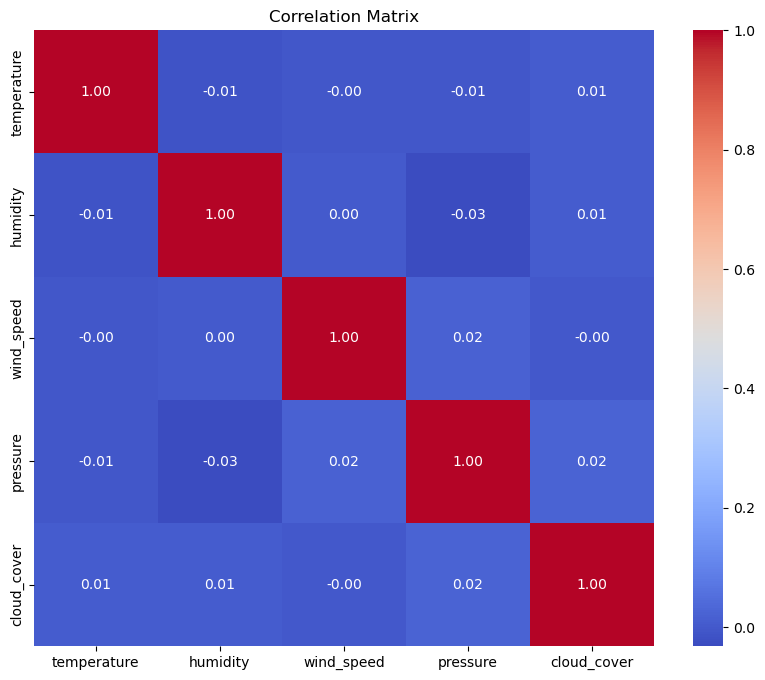

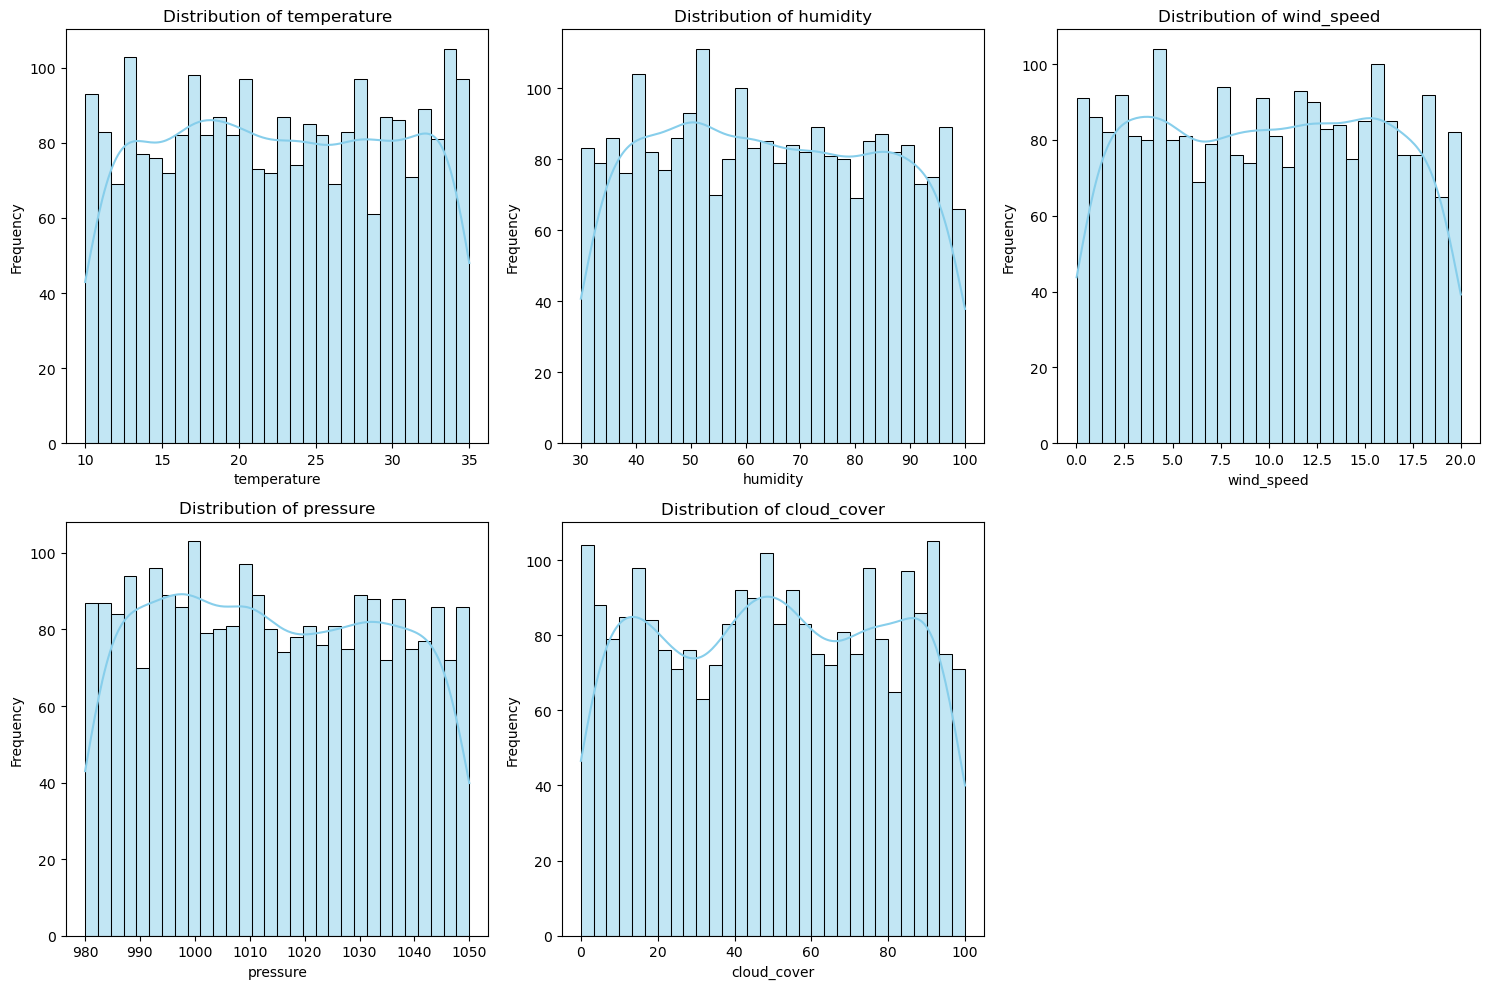

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Check for missing values in the dataset
missing_values = denormalized_data.isnull().sum()
print("Missing Values in Dataset:")
print(missing_values)

# Exclude non-numerical columns for the correlation matrix
numerical_data = denormalized_data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for numerical features
correlation_matrix = numerical_data.corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

# Plot histograms for numerical features to inspect distributions and identify outliers
numerical_features = ['temperature', 'humidity', 'wind_speed', 'pressure', 'cloud_cover']

plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(denormalized_data[feature], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [55]:
pip install -q dagshub mlflow


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-profiling 3.2.0 requires joblib~=1.1.0, but you have joblib 1.4.2 which is incompatible.
pandas-profiling 3.2.0 requires visions[type_image_path]==0.7.4, but you have visions 0.7.6 which is incompatible.
ydata-profiling 4.12.1 requires dacite>=1.8, but you have dacite 1.6.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install -q dagshub mlflow

Note: you may need to restart the kernel to use updated packages.


In [3]:
import dagshub
dagshub.init(repo_owner='vijaykrishnareddy09', repo_name='my-first-repo', mlflow=True)

Accessing as vijaykrishnareddy99

Initialized MLflow to track repo "vijaykrishnareddy09/my-first-repo"

Repository vijaykrishnareddy09/my-first-repo initialized!

In [11]:
pip install mlflow dagsHub scikit-learn pandas


Note: you may need to restart the kernel to use updated packages.


In [9]:
import sqlite3
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'  # Update with your actual path
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Define preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p))
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define cross-validation strategies
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform 3-fold cross-validation
cv_results_3 = cross_validate(pipeline, X, y, cv=cv3, scoring='f1', return_train_score=True)
mean_f1_3 = np.mean(cv_results_3['test_score'])
std_f1_3 = np.std(cv_results_3['test_score'])

# Perform 10-fold cross-validation
cv_results_10 = cross_validate(pipeline, X, y, cv=cv10, scoring='f1', return_train_score=True)
mean_f1_10 = np.mean(cv_results_10['test_score'])
std_f1_10 = np.std(cv_results_10['test_score'])

# Fit the model on the entire dataset
pipeline.fit(X, y)
y_pred = pipeline.predict(X)

# Calculate metrics on the full dataset
f1_training = f1_score(y, y_pred, pos_label='rain')
tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=['no rain', 'rain']).ravel()

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__penalty': ['l2', 'l1']
}
grid_search = GridSearchCV(pipeline, param_grid, cv=cv3, scoring='f1', n_jobs=-1)
grid_search.fit(X, y)

# Best parameters from GridSearchCV
best_params = grid_search.best_params_

# Output results in the Jupyter Notebook
print("=== Cross-Validation Results ===")
print(f"3-Fold CV F1-Score: Mean={mean_f1_3:.4f}, Std={std_f1_3:.4f}")
print(f"10-Fold CV F1-Score: Mean={mean_f1_10:.4f}, Std={std_f1_10:.4f}")

print("\n=== Training Results ===")
print(f"Training F1-Score: {f1_training:.4f}")
print(f"Confusion Matrix:\nTP={tp}, TN={tn}, FP={fp}, FN={fn}")

print("\n=== Hyperparameter Tuning ===")
print(f"Best Parameters: {best_params}")


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

=== Cross-Validation Results ===
3-Fold CV F1-Score: Mean=nan, Std=nan
10-Fold CV F1-Score: Mean=nan, Std=nan

=== Training Results ===
Training F1-Score: 0.6441
Confusion Matrix:
TP=162, TN=2159, FP=27, FN=152

=== Hyperparameter Tuning ===
Best Parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2'}


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 371, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 89,

In [17]:
pip install -q dagshub mlflow scikit-learn pandas numpy


Note: you may need to restart the kernel to use updated packages.


In [11]:
import dagshub
import mlflow
import mlflow.sklearn
import sqlite3
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# Initialize DagsHub for MLflow tracking
dagshub.init(repo_owner='vijaykrishnareddy99', repo_name='my-first-repo', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("LogisticRegressionPipeline")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'  # Update with your actual path
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Ensure no invalid values in numeric features
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

X[numeric_features] = X[numeric_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p))
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear', max_iter=1000))
])

# Define cross-validation strategies
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

with mlflow.start_run():
    # Perform 3-fold cross-validation
    cv_results_3 = cross_validate(pipeline, X, y, cv=cv3, scoring='f1_macro', return_train_score=True)
    mean_f1_3 = np.mean(cv_results_3['test_score'])
    std_f1_3 = np.std(cv_results_3['test_score'])
    mlflow.log_metric("f1_score_cv_3_mean", mean_f1_3)
    mlflow.log_metric("f1_score_cv_3_std", std_f1_3)

    # Perform 10-fold cross-validation
    cv_results_10 = cross_validate(pipeline, X, y, cv=cv10, scoring='f1_macro', return_train_score=True)
    mean_f1_10 = np.mean(cv_results_10['test_score'])
    std_f1_10 = np.std(cv_results_10['test_score'])
    mlflow.log_metric("f1_score_cv_10_mean", mean_f1_10)
    mlflow.log_metric("f1_score_cv_10_std", std_f1_10)

    # Fit the model on the entire dataset
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)

    # Calculate metrics on the full dataset
    f1_training = f1_score(y, y_pred, pos_label='rain', average='binary')
    tn, fp, fn, tp = confusion_matrix(y, y_pred, labels=['no rain', 'rain']).ravel()

    # Log metrics
    mlflow.log_metric("f1_score_training", f1_training)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Hyperparameter tuning
    param_grid = {
        'classifier__C': [0.1, 1, 10],
        'classifier__penalty': ['l2', 'l1']
    }
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X, y)

    # Log best parameters
    best_params = grid_search.best_params_
    mlflow.log_param("best_params", best_params)

    print("=== Cross-Validation Results ===")
    print(f"3-Fold CV F1-Score: Mean={mean_f1_3:.4f}, Std={std_f1_3:.4f}")
    print(f"10-Fold CV F1-Score: Mean={mean_f1_10:.4f}, Std={std_f1_10:.4f}")

    print("\n=== Training Results ===")
    print(f"Training F1-Score: {f1_training:.4f}")
    print(f"Confusion Matrix:\nTP={tp}, TN={tn}, FP={fp}, FN={fn}")

    print("\n=== Hyperparameter Tuning ===")
    print(f"Best Parameters: {best_params}")


Accessing as vijaykrishnareddy99

Initialized MLflow to track repo "vijaykrishnareddy99/my-first-repo"

Repository vijaykrishnareddy99/my-first-repo initialized!

=== Cross-Validation Results ===
3-Fold CV F1-Score: Mean=0.7775, Std=0.0323
10-Fold CV F1-Score: Mean=0.7937, Std=0.0354

=== Training Results ===
Training F1-Score: 0.6441
Confusion Matrix:
TP=162, TN=2159, FP=27, FN=152

=== Hyperparameter Tuning ===
Best Parameters: {'classifier__C': 10, 'classifier__penalty': 'l1'}
🏃 View run magnificent-gnu-471 at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/11/runs/178d7d65ca1e48909125933124345d29
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/11


In [7]:
dagshub.init(repo_owner='vijaykrishnareddy09', repo_name='my-first-repo', mlflow=True)


Initialized MLflow to track repo "vijaykrishnareddy09/my-first-repo"

Repository vijaykrishnareddy09/my-first-repo initialized!

In [13]:
import sqlite3
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("ClassifierComparisonExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Define preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p))
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(solver='liblinear', max_iter=1000),
    "RidgeClassifier": RidgeClassifier(),
    "RandomForestClassifier": RandomForestClassifier(),
    "XGBClassifier": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define cross-validation strategy
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run experiments
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=clf_name):
        # Define the pipeline
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', clf)
        ])

        # Perform 3-fold cross-validation
        cv_results_3 = cross_validate(pipeline, X, y, cv=cv3, scoring='f1', return_train_score=True)
        mean_f1_3 = np.mean(cv_results_3['test_score'])
        std_f1_3 = np.std(cv_results_3['test_score'])

        # Perform 10-fold cross-validation
        cv_results_10 = cross_validate(pipeline, X, y, cv=cv10, scoring='f1', return_train_score=True)
        mean_f1_10 = np.mean(cv_results_10['test_score'])
        std_f1_10 = np.std(cv_results_10['test_score'])

        # Fit the model on the entire dataset
        pipeline.fit(X, y)
        y_pred = pipeline.predict(X)

        # Calculate metrics on the full dataset
        f1_training = f1_score(y, y_pred, pos_label=1)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Log metrics
        mlflow.log_metric("f1_score_cv_3_mean", mean_f1_3)
        mlflow.log_metric("f1_score_cv_3_std", std_f1_3)
        mlflow.log_metric("f1_score_cv_10_mean", mean_f1_10)
        mlflow.log_metric("f1_score_cv_10_std", std_f1_10)
        mlflow.log_metric("f1_score_training", f1_training)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)
        mlflow.log_metric("tp", tp)

        # Log the model
        mlflow.sklearn.log_model(pipeline, clf_name)

print("Experiment2 completed and logged successfully.")


2024/12/22 01:00:40 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13/runs/39a103b71370494e84250147a21de147
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13


2024/12/22 01:00:59 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RidgeClassifier at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13/runs/406e3c548fd343358ff94de51bc2ad16
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13


2024/12/22 01:01:18 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForestClassifier at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13/runs/a4b6b3f70c8a448d819d8172279d3346
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:01:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBClassifier at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13/runs/00233fde6bca4abb89495b1e5c9c7fbb
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/13
Experiment2 completed and logged successfully.


In [15]:
import sqlite3
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("FeatureEngineeringExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Create new attributes
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)  # Avoid division by zero
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Define preprocessing pipeline
numeric_features = X.select_dtypes(include=['float64', 'int64']).columns
categorical_features = X.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p))
        ]), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])

# Define classifier
classifier = LogisticRegression(solver='liblinear', max_iter=1000)

# Define cross-validation strategy
cv3 = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Run experiment
with mlflow.start_run(run_name="FeatureEngineering_LogisticRegression"):
    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform 3-fold cross-validation
    cv_results_3 = cross_validate(pipeline, X, y, cv=cv3, scoring='f1', return_train_score=True)
    mean_f1_3 = np.mean(cv_results_3['test_score'])
    std_f1_3 = np.std(cv_results_3['test_score'])

    # Perform 10-fold cross-validation
    cv_results_10 = cross_validate(pipeline, X, y, cv=cv10, scoring='f1', return_train_score=True)
    mean_f1_10 = np.mean(cv_results_10['test_score'])
    std_f1_10 = np.std(cv_results_10['test_score'])

    # Fit the model on the entire dataset
    pipeline.fit(X, y)
    y_pred = pipeline.predict(X)

    # Calculate metrics on the full dataset
    f1_training = f1_score(y, y_pred, pos_label=1)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log metrics
    mlflow.log_metric("f1_score_cv_3_mean", mean_f1_3)
    mlflow.log_metric("f1_score_cv_3_std", std_f1_3)
    mlflow.log_metric("f1_score_cv_10_mean", mean_f1_10)
    mlflow.log_metric("f1_score_cv_10_std", std_f1_10)
    mlflow.log_metric("f1_score_training", f1_training)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    mlflow.sklearn.log_model(pipeline, "LogisticRegression_FeatureEngineering")

print("Experiment3 completed and logged successfully.")


2024/12/22 01:01:56 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run FeatureEngineering_LogisticRegression at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/14/runs/4cc7cf6cedb64551bc3ef7c08fea8028
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/14
Experiment3 completed and logged successfully.


In [17]:
import sqlite3
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("FeatureSelectionExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Add new features
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)  # Avoid division by zero
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Correlation Threshold Feature Selection
correlation_matrix = X.corr()
correlation_threshold = 0.9
correlated_features = set(
    [
        feature
        for feature in correlation_matrix.columns
        for other_feature in correlation_matrix.columns
        if feature != other_feature and abs(correlation_matrix[feature][other_feature]) > correlation_threshold
    ]
)
X_corr_selected = X.drop(columns=correlated_features)

# Variance Threshold Feature Selection
variance_selector = VarianceThreshold(threshold=0.01)
X_variance_selected = variance_selector.fit_transform(X_corr_selected)
selected_variance_features = X_corr_selected.columns[variance_selector.get_support()]

# Feature Importance using RandomForest
forest = RandomForestClassifier(random_state=42)
forest.fit(X_corr_selected, y)
importances = forest.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
top_features = X_corr_selected.columns[sorted_indices][:5]
X_final_selected = X_corr_selected[top_features]

# Define preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('minmax', MinMaxScaler()),
            ('log', FunctionTransformer(np.log1p))
        ]), top_features)
    ]
)

# Define the classifier
classifier = RandomForestClassifier(random_state=42)

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run experiment
with mlflow.start_run(run_name="FeatureSelection_RF"):
    # Define the pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', classifier)
    ])

    # Perform cross-validation
    cv_results = cross_validate(pipeline, X_final_selected, y, cv=cv, scoring='f1', return_train_score=True)
    mean_f1 = np.mean(cv_results['test_score'])
    std_f1 = np.std(cv_results['test_score'])

    # Fit the model on the entire dataset
    pipeline.fit(X_final_selected, y)
    y_pred = pipeline.predict(X_final_selected)

    # Calculate metrics on the full dataset
    f1_training = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log selected features
    mlflow.log_param("correlation_removed_features", list(correlated_features))
    mlflow.log_param("variance_selected_features", list(selected_variance_features))
    mlflow.log_param("top_features", list(top_features))

    # Log metrics
    mlflow.log_metric("f1_score_cv_mean", mean_f1)
    mlflow.log_metric("f1_score_cv_std", std_f1)
    mlflow.log_metric("f1_score_training", f1_training)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log the model
    mlflow.sklearn.log_model(pipeline, "FeatureSelection_RF_Model")

print("Experiment4 completed and logged successfully.")


2024/12/22 01:02:16 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run FeatureSelection_RF at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/15/runs/5ca0678d248b4854aff97c8a10905415
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/15
Experiment4 completed and logged successfully.


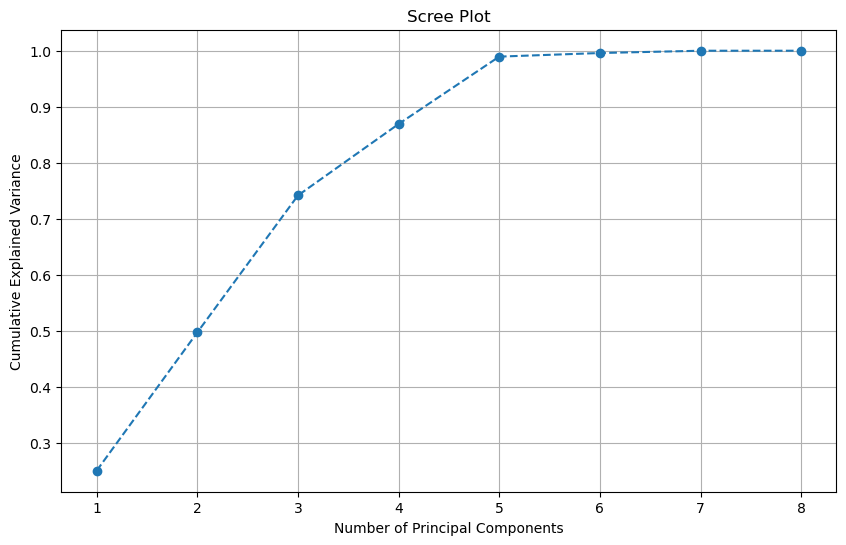

2024/12/22 01:02:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run PCA_RF at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/16/runs/a4a30d52ad8342d9b9a095fb5ad404a3
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/16
Experiment5 completed and logged successfully.


In [19]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import mlflow

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("PCAExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Add new features
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)  # Avoid division by zero
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Scree Plot
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Scree Plot')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.savefig("scree_plot.png")
plt.show()

# Decide the number of components to retain (e.g., 95% explained variance)
n_components = np.argmax(cumulative_variance_ratio >= 0.95) + 1
X_reduced = X_pca[:, :n_components]

# Define classifier
classifier = RandomForestClassifier(random_state=42)

# Cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Run experiment
with mlflow.start_run(run_name="PCA_RF"):
    # Perform cross-validation
    cv_results = cross_validate(classifier, X_reduced, y, cv=cv, scoring='f1', return_train_score=True)
    mean_f1 = np.mean(cv_results['test_score'])
    std_f1 = np.std(cv_results['test_score'])

    # Fit the model on the reduced dataset
    classifier.fit(X_reduced, y)
    y_pred = classifier.predict(X_reduced)

    # Calculate metrics on the full dataset
    f1_training = f1_score(y, y_pred)
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

    # Log metrics
    mlflow.log_param("n_components", n_components)
    mlflow.log_metric("f1_score_cv_mean", mean_f1)
    mlflow.log_metric("f1_score_cv_std", std_f1)
    mlflow.log_metric("f1_score_training", f1_training)
    mlflow.log_metric("tn", tn)
    mlflow.log_metric("fp", fp)
    mlflow.log_metric("fn", fn)
    mlflow.log_metric("tp", tp)

    # Log scree plot and model
    mlflow.log_artifact("scree_plot.png")
    mlflow.sklearn.log_model(classifier, "PCA_RF_Model")

print("Experiment5 completed and logged successfully.")


In [21]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow
import matplotlib.pyplot as plt

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("CustomExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Add new features
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=5)  # Keep top 5 principal components
X_pca = pca.fit_transform(X_scaled)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recursive Feature Elimination (RFE)
results = []
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name}_PCA_RFE"):
        # Recursive Feature Elimination
        rfe = RFE(estimator=clf, n_features_to_select=5)
        rfe.fit(X_pca, y)
        selected_features = np.where(rfe.support_)[0]

        # Visualize feature rankings
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
        plt.title(f"Feature Rankings from RFE ({clf_name})")
        plt.xlabel("Feature Index")
        plt.ylabel("Ranking")
        plt.grid(True)
        plt.savefig(f"rfe_feature_rankings_{clf_name}.png")
        plt.close()

        # Cross-validation with selected features
        cv_results = cross_validate(clf, X_pca[:, selected_features], y, cv=cv, scoring='f1', return_train_score=True)
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        # Train on the entire dataset
        clf.fit(X_pca[:, selected_features], y)
        y_pred = clf.predict(X_pca[:, selected_features])

        # Metrics
        f1_training = f1_score(y, y_pred)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Log parameters, metrics, and artifacts
        mlflow.log_param("pca_components", pca.n_components)
        mlflow.log_param("selected_features", list(selected_features))
        mlflow.log_metric("f1_score_cv_mean", mean_f1)
        mlflow.log_metric("f1_score_cv_std", std_f1)
        mlflow.log_metric("f1_score_training", f1_training)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)
        mlflow.log_metric("tp", tp)
        mlflow.log_artifact(f"rfe_feature_rankings_{clf_name}.png")
        mlflow.sklearn.log_model(clf, f"{clf_name}_model")

        results.append({
            "Classifier": clf_name,
            "F1_CV_Mean": mean_f1,
            "F1_CV_Std": std_f1,
            "F1_Training": f1_training,
            "TP": tp, "TN": tn, "FP": fp, "FN": fn
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_csv("experiment6_results.csv", index=False)


2024/12/22 01:03:24 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/2a2a4f012ab14d02a3d48dd22f6cdcff
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


2024/12/22 01:03:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/67c4379513bc4774abe9261f61e3b1a3
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


2024/12/22 01:04:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVM_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/dbfab5c46b254a45afa47965c7e32521
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [01:04:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBoost_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/aed661d6fcce43eeab22bfd5be86d008
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17
           Classifier  F1_CV_Mean  F1_CV_Std  F1_Training   TP    TN  FP   FN
0  LogisticRegression    0.688660   0.019891     0.689655  200  2120  66  114
1        RandomForest    0.818424   0.015034     1.000000  314  2186   0    0
2                 SVM    0.879520   0.028357     0.908497  278  2166  20   36
3             XGBoost    0.869665   0.040312     1.000000  314  2186   0    0


In [25]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow
import matplotlib.pyplot as plt

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("CustomExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Add new features
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=5)  # Keep top 5 principal components
X_pca = pca.fit_transform(X_scaled)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recursive Feature Elimination (RFE)
results = []
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name}_PCA_RFE"):
        # Recursive Feature Elimination
        rfe = RFE(estimator=clf, n_features_to_select=5)
        rfe.fit(X_pca, y)
        selected_features = np.where(rfe.support_)[0]

        # Visualize feature rankings
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(rfe.ranking_)), rfe.ranking_)
        plt.xticks(range(len(rfe.ranking_)), [f"Feature {i+1}" for i in range(len(rfe.ranking_))], rotation=45)  # Add feature names below
        plt.title(f"Feature Rankings from RFE ({clf_name})")
        plt.xlabel("Feature Index")
        plt.ylabel("Ranking")
        plt.grid(True)
        rfe_plot_path = f"rfe_feature_rankings_{clf_name}.png"
        plt.savefig(rfe_plot_path)
        plt.close()  # Close the plot to free memory

        # Cross-validation with selected features
        cv_results = cross_validate(clf, X_pca[:, selected_features], y, cv=cv, scoring='f1', return_train_score=True)
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        # Train on the entire dataset
        clf.fit(X_pca[:, selected_features], y)
        y_pred = clf.predict(X_pca[:, selected_features])

        # Metrics
        f1_training = f1_score(y, y_pred)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()

        # Log parameters, metrics, and artifacts
        mlflow.log_param("pca_components", pca.n_components)
        mlflow.log_param("selected_features", list(selected_features))
        mlflow.log_metric("f1_score_cv_mean", mean_f1)
        mlflow.log_metric("f1_score_cv_std", std_f1)
        mlflow.log_metric("f1_score_training", f1_training)
        mlflow.log_metric("tn", tn)
        mlflow.log_metric("fp", fp)
        mlflow.log_metric("fn", fn)
        mlflow.log_metric("tp", tp)
        mlflow.log_artifact(rfe_plot_path)
        mlflow.sklearn.log_model(clf, f"{clf_name}_model")

        # Append results for the current classifier
        results.append({
            "Classifier": clf_name,
            "F1_CV_Mean": mean_f1,
            "F1_CV_Std": std_f1,
            "F1_Training": f1_training,
            "TP": tp, "TN": tn, "FP": fp, "FN": fn
        })

# Display results
results_df = pd.DataFrame(results)
print(results_df)

# Save results to CSV
results_df.to_csv("experiment6_results.csv", index=False)


2024/12/21 12:34:42 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run LogisticRegression_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/c89e4e62ae904c2282546a93aff013c3
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


2024/12/21 12:35:02 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run RandomForest_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/2b2a9bd2b7f04414a49524891d0c5743
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


2024/12/21 12:35:22 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run SVM_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/6e89e5e6b904467ca72f2cbf9180c079
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [12:35:30] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBoost_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/6dc8ca427c6f41539e9c4fda8dcb2971
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17
           Classifier  F1_CV_Mean  F1_CV_Std  F1_Training   TP    TN  FP   FN
0  LogisticRegression    0.688660   0.019891     0.689655  200  2120  66  114
1        RandomForest    0.818424   0.015034     1.000000  314  2186   0    0
2                 SVM    0.879520   0.028357     0.908497  278  2166  20   36
3             XGBoost    0.869665   0.040312     1.000000  314  2186   0    0


🏃 View run LogisticRegression_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/de5159021330406da2684546e94ce916
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17
🏃 View run RandomForest_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/7cd75c98d8f14f2d982191b34e133540
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17
🏃 View run SVM_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/110fff540a0a445b8013c76e0f496839
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [15:30:22] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

🏃 View run XGBoost_PCA_RFE at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17/runs/ccabd6b1ff36430ab247e349dc1762d6
🧪 View experiment at: https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow/#/experiments/17
           Classifier  F1_CV_Mean  F1_CV_Std  F1_Training
0  LogisticRegression    0.688660   0.019891     0.689655
1        RandomForest    0.818424   0.015034     1.000000
2                 SVM    0.879520   0.028357     0.908497
3             XGBoost    0.869665   0.040312     1.000000


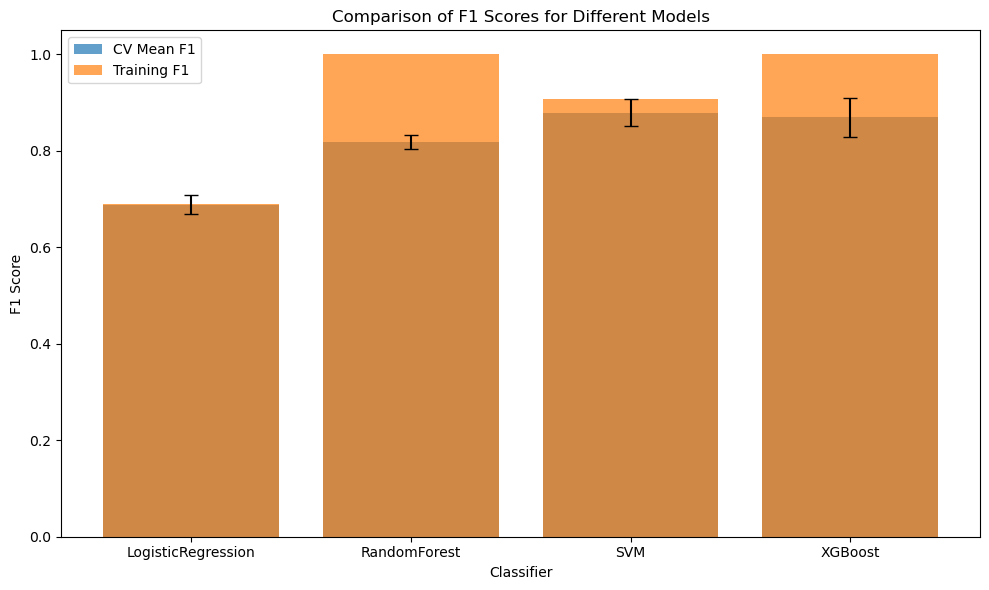

In [22]:
import sqlite3
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np
import mlflow
import matplotlib.pyplot as plt

# Set up MLflow tracking
mlflow.set_tracking_uri("https://dagshub.com/vijaykrishnareddy99/my-first-repo.mlflow")
mlflow.set_experiment("CustomExperiment")

# Connect to the SQLite database
db_path = '/Users/vijaykrishnareddy/Downloads/weather_forecast_normalized.db'
conn = sqlite3.connect(db_path)

# Query to fetch the required data
query = """
SELECT 
    wc.temperature, wc.humidity, wc.wind_speed, wc.pressure, cc.cloud_cover, rs.rain_status
FROM WeatherRecords wr
JOIN WeatherConditions wc ON wr.weather_condition_id = wc.id
JOIN CloudCoverage cc ON wr.cloud_coverage_id = cc.id
JOIN RainStatus rs ON wr.rain_status_id = rs.id
"""
data = pd.read_sql(query, conn)
conn.close()

# Feature Engineering: Add new features
data['temp_humidity_ratio'] = data['temperature'] / (data['humidity'] + 1e-3)
data['pressure_wind_product'] = data['pressure'] * data['wind_speed']
data['cloud_impact'] = data['cloud_cover'] ** 2

# Convert target to binary
data['rain_status'] = data['rain_status'].map({'no rain': 0, 'rain': 1})

# Split features and target
X = data.drop(columns=['rain_status'])
y = data['rain_status']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA(n_components=5)  # Keep top 5 principal components
X_pca = pca.fit_transform(X_scaled)

# Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "RandomForest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

# Define cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Recursive Feature Elimination (RFE)
results = []
for clf_name, clf in classifiers.items():
    with mlflow.start_run(run_name=f"{clf_name}_PCA_RFE"):
        # Recursive Feature Elimination
        rfe = RFE(estimator=clf, n_features_to_select=5)
        rfe.fit(X_pca, y)
        selected_features = np.where(rfe.support_)[0]

        # Cross-validation with selected features
        cv_results = cross_validate(clf, X_pca[:, selected_features], y, cv=cv, scoring='f1', return_train_score=True)
        mean_f1 = np.mean(cv_results['test_score'])
        std_f1 = np.std(cv_results['test_score'])

        # Train on the entire dataset
        clf.fit(X_pca[:, selected_features], y)
        y_pred = clf.predict(X_pca[:, selected_features])

        # Metrics
        f1_training = f1_score(y, y_pred)
        
        # Append results for the current classifier
        results.append({
            "Classifier": clf_name,
            "F1_CV_Mean": mean_f1,
            "F1_CV_Std": std_f1,
            "F1_Training": f1_training
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display results
print(results_df)

# Create F1-score Comparison Plot (Bar plot)
plt.figure(figsize=(10, 6))

# Plot mean F1 scores (CV)
plt.bar(results_df['Classifier'], results_df['F1_CV_Mean'], yerr=results_df['F1_CV_Std'], capsize=5, label="CV Mean F1", alpha=0.7)

# Plot training F1 scores
plt.bar(results_df['Classifier'], results_df['F1_Training'], alpha=0.7, label="Training F1")

# Add labels and title
plt.title('Comparison of F1 Scores for Different Models')
plt.xlabel('Classifier')
plt.ylabel('F1 Score')
plt.legend()

# Show plot in Jupyter
plt.tight_layout()
plt.show()

# Save results to CSV
results_df.to_csv("experiment6_results.csv", index=False)


In [22]:
import joblib

# Save the trained model pipeline
joblib_file = "weather_forecast_model.pkl"  # File to save the model
joblib.dump(pipeline, joblib_file)  # Assuming `pipeline` contains the trained model pipeline
print(f"Model saved successfully to {joblib_file}")

Model saved successfully to weather_forecast_model.pkl


In [25]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib
import numpy as np

# Load the saved model
model = joblib.load("weather_forecast_model.pkl")  # Match with the saved model file

# Initialize FastAPI app
app = FastAPI()

# Define the input schema
class WeatherInput(BaseModel):
    temperature: float
    humidity: float
    wind_speed: float
    pressure: float
    cloud_cover: float

# Define the prediction endpoint
@app.post("/predict")
def predict_weather(data: WeatherInput):
    # Prepare input for the model
    input_data = np.array([[data.temperature, data.humidity, data.wind_speed, data.pressure, data.cloud_cover]])
    
    # Make prediction
    prediction = model.predict(input_data)
    rain_status = "rain" if prediction[0] == 1 else "no rain"
    
    return {"rain_status": rain_status}


In [27]:
import os

# Create the directory if it doesn't exist
os.makedirs("weather_forecast_app", exist_ok=True)
print("Directory 'weather_forecast_app' created or already exists.")

Directory 'weather_forecast_app' created or already exists.


In [29]:
import subprocess

# Set Docker image name
docker_image_name = "vijay3999/weather-forecast-api:latest"

# Build Docker image
try:
    subprocess.run(["docker", "build", "-t", docker_image_name, "."], check=True)
    print(f"Docker image '{docker_image_name}' built successfully!")
except subprocess.CalledProcessError as e:
    print(f"Error building Docker image: {e}")


#0 building with "desktop-linux" instance using docker driver

#1 [internal] load build definition from Dockerfile
#1 transferring dockerfile: 532B done
#1 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.9-slim
#2 ...

#3 [auth] library/python:pull token for registry-1.docker.io
#3 DONE 0.0s

#2 [internal] load metadata for docker.io/library/python:3.9-slim
#2 DONE 0.5s

#4 [internal] load .dockerignore
#4 transferring context: 2B done
#4 DONE 0.0s

#5 [1/4] FROM docker.io/library/python:3.9-slim@sha256:4ee0613170ac55ebc693a03b6655a5c6f387126f6bc3390e739c2e6c337880ef
#5 resolve docker.io/library/python:3.9-slim@sha256:4ee0613170ac55ebc693a03b6655a5c6f387126f6bc3390e739c2e6c337880ef done
#5 DONE 0.0s

#6 [internal] load build context
#6 transferring context: 3.56MB 0.0s done
#6 DONE 0.0s

#7 [2/4] WORKDIR /app
#7 CACHED

#8 [3/4] COPY . /app
#8 DONE 0.0s

#9 [4/4] RUN pip install --no-cache-dir fastapi uvicorn joblib numpy pydantic
#9 1.082 Collecting fastapi
#9 1.

Docker image 'vijay3999/weather-forecast-api:latest' built successfully!


#10 unpacking to docker.io/vijay3999/weather-forecast-api:latest 0.3s done
#10 DONE 1.7s

View build details: docker-desktop://dashboard/build/desktop-linux/desktop-linux/mfynoszhggobrltpdxpiis8oo


In [35]:
import subprocess

# Set Docker image name
docker_image_name = "vijay3999/weather-forecast-api:latest"  # Replace with your Docker Hub repository and image name

# Push Docker image to Docker Hub
try:
    # Login to Docker Hub (you may need to enter credentials manually if not already logged in)
    subprocess.run(["docker", "login"], check=True)
    
    # Push the image
    subprocess.run(["docker", "push", docker_image_name], check=True)
    
    print(f"Docker image '{docker_image_name}' pushed to Docker Hub successfully!")
except subprocess.CalledProcessError as e:
    print(f"Error pushing Docker image: {e}")

Authenticating with existing credentials...
Login Succeeded
The push refers to repository [docker.io/vijay3999/weather-forecast-api]
a3bae8c1d14f: Waiting
e88090b39a19: Waiting
0e277233a7cd: Waiting
b17061f37db5: Waiting
8e622847ac29: Waiting
5dd97a70d84c: Waiting
cd87c688b22f: Waiting
bb3f2b52e6af: Waiting
a3bae8c1d14f: Waiting
e88090b39a19: Waiting
0e277233a7cd: Waiting
b17061f37db5: Waiting
8e622847ac29: Waiting
5dd97a70d84c: Waiting
cd87c688b22f: Waiting
bb3f2b52e6af: Waiting
8e622847ac29: Waiting
5dd97a70d84c: Waiting
cd87c688b22f: Waiting
bb3f2b52e6af: Waiting
a3bae8c1d14f: Waiting
e88090b39a19: Waiting
0e277233a7cd: Waiting
b17061f37db5: Waiting
a3bae8c1d14f: Waiting
e88090b39a19: Waiting
0e277233a7cd: Waiting
b17061f37db5: Waiting
8e622847ac29: Waiting
5dd97a70d84c: Waiting
cd87c688b22f: Waiting
bb3f2b52e6af: Waiting
e88090b39a19: Waiting
0e277233a7cd: Waiting
b17061f37db5: Waiting
8e622847ac29: Waiting
5dd97a70d84c: Waiting
cd87c688b22f: Waiting
bb3f2b52e6af: Waiting
a3bae8c1d

In [37]:
import subprocess

# Set Docker image name
docker_image_name = "vijay3999/weather-forecast-api:latest"  # Replace with your image name

# Container port mapping
container_port = 8000
host_port = 8000

# Run Docker container
try:
    subprocess.run([
        "docker", "run", "-d", "-p", f"{host_port}:{container_port}", docker_image_name
    ], check=True)
    print(f"Docker container for image '{docker_image_name}' is running on port {host_port}!")
except subprocess.CalledProcessError as e:
    print(f"Error running Docker container: {e}")


8a026f3aebb2067ea023f4cf6fdd09992f2fb77f13fc2ea550c34322c8fbc284
Docker container for image 'vijay3999/weather-forecast-api:latest' is running on port 8000!
